In [1]:
# Run this cell before continuing.
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Examining Correlations between location and crime Rates

## Introduction
---

Recently, the rates of crimes in the east of Vancouver have surged, prompting an exploration into the extent of this increase. The pressing question arises: just how elevated are these crime rates?

Our dataset contains crime data for 2022 in Vancouver. For each entry, we have recorded the type of crime, and we are specifically focusing on three crime types: "Break and Enter Residential/Other," "Break and Enter Commercial," and "Mischief." We also have information about the date and time the crime occurred, the address, neighborhood, and geographic coordinates.

The question we are trying to answer is: are the crime rates in east of vancouver 2 times more than west of vancouver? as defined by the "X" coordinate. Crimes with "X" values less than 491017.47 are categorized as the "west" side, while values greater than or equal to this threshold are considered the "east" side.

In this study, we created a new column REGION which will used to find the proportion of crimes in east and west. This approach allows us to focus on the geographical aspect of crime patterns for "Break and Enter Residential/Other," "Break and Enter Commercial," and "Mischief" incidents. 

Downtown Vancouver and hasting street have frequently been associated with higher rates of criminality, according to many news and these are one of the most hazardous locations in Vancouver. Higher levels of socioeconomic inequality, poverty, or other social factors in west vancouver are associated with higher crime rates, it could contribute to an elevated crime rate compared to the east side. our null hypothesis is that the crime rate in east is 2 times more than crime rate in west. Our alternative hypothesis is that crime rate in east is not 2 times more than crime rate in west. 

### Parameters of Interest:

* Location Parameter (Proportion): 

H0: p_east >= 0.67

H1: p_east < 0.67

* Scale Parameter (Standard Deviation):

The standard deviation will be a secondary parameter of interest. We'll calculate the standard deviation for each crime type in both west and east sides of Vancouver. This parameter is important because it allows us to assess the variability or dispersion of crime occurrences within each group. It can help us understand how consistent or variable crime patterns are in each area.

## Preliminary Results
---

In [2]:
# setwd("/home/jovyan/work/project")

In [3]:
crime_data <- read_csv("https://raw.githubusercontent.com/aradsab/Stat-201-Project/main/crimedata_csv_AllNeighbourhoods_2022.csv")
# cleaning the data
crime_data <- crime_data[complete.cases(crime_data), ]
crime_data <- subset(crime_data, X != 0)
crime_data <- crime_data %>%
  mutate(REGION = ifelse(X > 491017.47, "East", "West"))

head(crime_data)

Rows: 34281 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,REGION
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Break and Enter Commercial,2022,1,3,16,19,10XX ALBERNI ST,West End,491036.1,5459146,East
Break and Enter Commercial,2022,6,17,5,16,10XX ALBERNI ST,West End,491067.3,5459115,East
Break and Enter Commercial,2022,3,15,5,14,10XX ALBERNI ST,West End,491102.2,5459092,East
Break and Enter Commercial,2022,3,19,6,42,10XX ALBERNI ST,West End,491102.2,5459092,East
Break and Enter Commercial,2022,2,23,23,0,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444,West
Break and Enter Commercial,2022,2,25,10,15,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444,West


In [4]:
crime_X <- crime_data[c("REGION","TYPE")]
head(crime_X)

REGION,TYPE
<chr>,<chr>
East,Break and Enter Commercial
East,Break and Enter Commercial
East,Break and Enter Commercial
East,Break and Enter Commercial
West,Break and Enter Commercial
West,Break and Enter Commercial


In [5]:
set.seed(124)

crime_res <- crime_X[crime_X$TYPE == "Break and Enter Residential/Other", ]
crime_com <- crime_X[crime_X$TYPE == "Break and Enter Commercial", ]
crime_mis <- crime_X[crime_X$TYPE == "Mischief", ]

crime_res_summary <- crime_res %>% group_by(REGION) %>% summarise(total_rows = n()) %>%
    mutate(proportion = total_rows / sum(total_rows))
crime_com_summary <- crime_com %>% group_by(REGION) %>% summarise(total_rows = n()) %>%
    mutate(proportion = total_rows / sum(total_rows))
crime_mis_summary <- crime_mis %>% group_by(REGION) %>% summarise(total_rows = n()) %>%
    mutate(proportion = total_rows / sum(total_rows))


tibble(crime_res_summary)
tibble(crime_com_summary)
tibble(crime_mis_summary)


REGION,total_rows,proportion
<chr>,<int>,<dbl>
East,801,0.6327014
West,465,0.3672986


REGION,total_rows,proportion
<chr>,<int>,<dbl>
East,1344,0.6770781
West,641,0.3229219


REGION,total_rows,proportion
<chr>,<int>,<dbl>
East,4349,0.7746705
West,1265,0.2253295


## Methods: Plan

---

In this section we are first using z-value testing with signifanct level of 0.05 then  we will proove the same result with bootstraping and find standard error.


#### P-values based on Theory based method

---

In [6]:
res_prop_east <- crime_res_summary$proportion[1]
confidence_level <- 0.95

# Calculate the standard error of the proportion
se <- sqrt(res_prop_east * (1 - res_prop_east) / 1266)


population_proportion_null <- 0.67  # Hypothesized population proportion under the null hypothesis


# Calculate z value
z_value <- (res_prop_east - population_proportion_null) / se

# Calculate the margin of error
margin_of_error_res <- z_value * se

p_value <- pnorm(z_value)
print(p_value)
print(margin_of_error_res)

[1] 0.002952944
[1] -0.03729858


In [7]:
com_prop_east <- crime_com_summary$proportion[1]

# Calculate the standard error of the proportion
se <- sqrt(com_prop_east * (1 - com_prop_east) / 1985)

# Calculate z value
z_value <- (com_prop_east - population_proportion_null) / se

# Calculate the margin of error
margin_of_error_com <- z_value * se

p_value <- pnorm(z_value)
print(p_value)
print(margin_of_error_com)

[1] 0.7499766
[1] 0.007078086


In [8]:
mis_prop_east <- crime_mis_summary$proportion[1]

# Calculate the standard error of the proportion
se <- sqrt(mis_prop_east * (1 - mis_prop_east) / 5614) 

# z value
z_value <- (mis_prop_east - population_proportion_null) / se

# margin of error
margin_of_error_mis <- z_value * se

p_value <- pnorm(z_value)
print(p_value)
print(margin_of_error_mis)

[1] 1
[1] 0.1046705



### Bootstraping

---

In [9]:
set.seed(123)

# Generate bootstrap samples and calculate proportions
props_btsp_ci_res <- 
  crime_res %>%
  rep_sample_n(size = 1266, reps = 1000, replace = TRUE) %>%
  group_by(replicate) %>%
  summarise(n_rows_east = sum(REGION == "East"), 
            proportion = n_rows_east / n()) 

# Calculate 95% confidence intervals
ci_intervals_res <- props_btsp_ci_res %>%
  summarise(ci_lower = quantile(proportion, 0.025), 
            ci_upper = quantile(proportion, 0.975))
ci_intervals_res

ci_lower,ci_upper
<dbl>,<dbl>
0.6058452,0.6587678


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


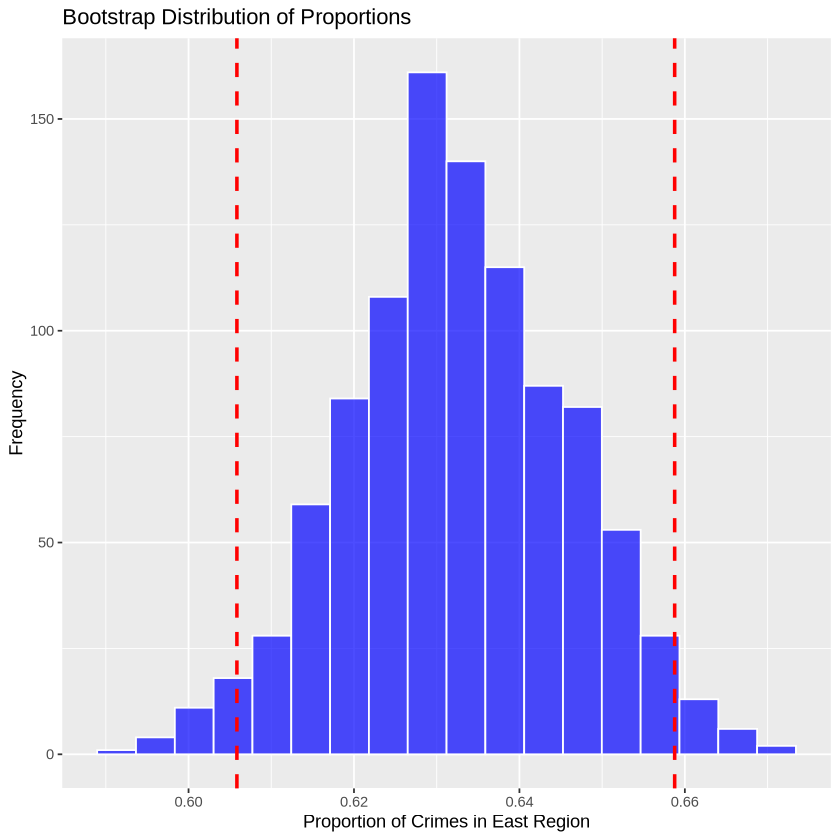

In [10]:
# Plot the histogram of proportions
ggplot(props_btsp_ci_res, aes(x = proportion)) +
  geom_histogram(bins = 18, fill = "blue", color = "white", alpha = 0.7) +
  labs(title = "Bootstrap Distribution of Proportions",
       x = "Proportion of Crimes in East Region",
       y = "Frequency") +
  
  # Add vertical lines for the confidence intervals
  geom_vline(xintercept = ci_intervals_res$ci_lower, linetype = "dashed", color = "red", size = 1) +
  geom_vline(xintercept = ci_intervals_res$ci_upper, linetype = "dashed", color = "red", size = 1) 

In [11]:
set.seed(123)

# Generate bootstrap samples and calculate proportions
props_btsp_ci_com <- 
  crime_com %>%
  rep_sample_n(size = 1985, reps = 1000, replace = TRUE) %>%
  group_by(replicate) %>%
  summarise(n_rows_east = sum(REGION == "East"), 
            proportion = n_rows_east / n()) 

# Calculate 95% confidence intervals
ci_intervals_com <- props_btsp_ci_com %>%
  summarise(ci_lower = quantile(proportion, 0.025), 
            ci_upper = quantile(proportion, 0.975))
ci_intervals_com

ci_lower,ci_upper
<dbl>,<dbl>
0.6569144,0.6967254


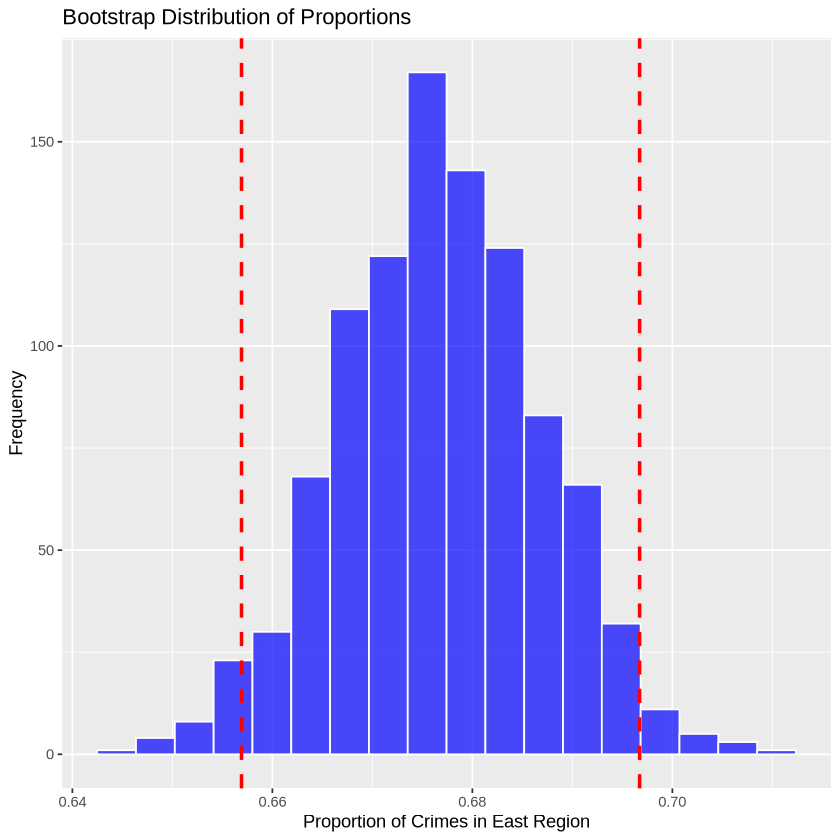

In [12]:
# Plot the histogram of proportions
ggplot(props_btsp_ci_com, aes(x = proportion)) +
  geom_histogram(bins = 18, fill = "blue", color = "white", alpha = 0.7) +
  labs(title = "Bootstrap Distribution of Proportions",
       x = "Proportion of Crimes in East Region",
       y = "Frequency") +
  
  # Add vertical lines for the confidence intervals
  geom_vline(xintercept = ci_intervals_com$ci_lower, linetype = "dashed", color = "red", size = 1) +
  geom_vline(xintercept = ci_intervals_com$ci_upper, linetype = "dashed", color = "red", size = 1) 

In [13]:
set.seed(123)

# Generate bootstrap samples and calculate proportions
props_btsp_ci_mis <- 
  crime_mis %>%
  rep_sample_n(size = 5614, reps = 1000, replace = TRUE) %>%
  group_by(replicate) %>%
  summarise(n_rows_east = sum(REGION == "East"), 
            proportion = n_rows_east / n()) 
# Calculate 95% confidence intervals

In [14]:
ci_intervals_mis <- props_btsp_ci_mis %>%
  summarise(ci_lower = quantile(proportion, 0.025), 
            ci_upper = quantile(proportion, 0.975))

ci_intervals_mis

ci_lower,ci_upper
<dbl>,<dbl>
0.7634485,0.7855406


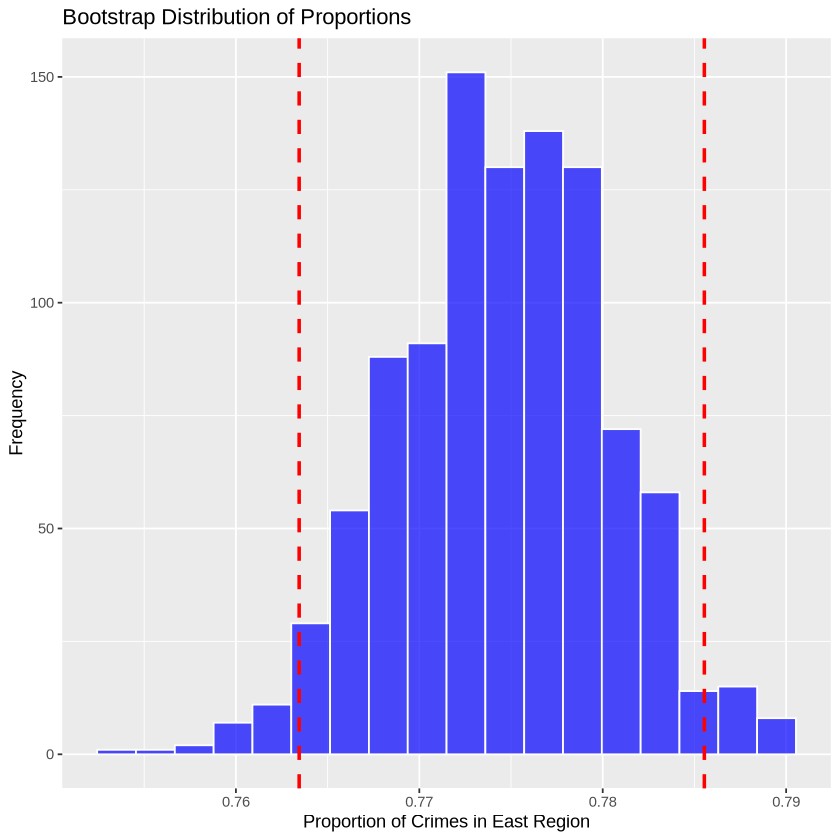

In [15]:

# Plot the histogram of proportions
ggplot(props_btsp_ci_mis, aes(x = proportion)) +
  geom_histogram(bins = 18, fill = "blue", color = "white", alpha = 0.7) +
  labs(title = "Bootstrap Distribution of Proportions",
       x = "Proportion of Crimes in East Region",
       y = "Frequency") +
  
  # Add vertical lines for the confidence intervals
  geom_vline(xintercept = ci_intervals_mis$ci_lower, linetype = "dashed", color = "red", size = 1) +
  geom_vline(xintercept = ci_intervals_mis$ci_upper, linetype = "dashed", color = "red", size = 1) 


#### P-values based on bootstraping

---

In [21]:
props_btsp_ci_res %>%
  mutate(right = proportion >= 0.67) %>%
  summarise(p_value_BE_res = sum(right)/1000)

p_value_BE_res
<dbl>
0.001


In [22]:
props_btsp_ci_com %>%
  mutate(right = proportion >= 0.67) %>%
  summarise(p_value_BE_com = sum(right)/1000)

p_value_BE_com
<dbl>
0.757


In [23]:
props_btsp_ci_mis %>%
  mutate(right = proportion >= 0.67) %>%
  summarise(p_value_mischief = sum(right)/1000)

p_value_mischief
<dbl>
1



References
Staysafevancouver. (2023, August 31). Vancouver crime rate: Areas to avoid. Stay Safe Vancouver. https://www.staysafevancouver.com/post/vancouver-crime-rate 

West side rated safer than East Side neighbourhoods: Vancouver police survey. The Georgia Straight. (2019, February 21). https://www.straight.com/news/1203621/west-side-rated-safer-east-side-neighbourhoods-vancouver-police-survey 
